In [ ]:
pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.5/239.5 kB 949.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.3/124.3 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.6/301.6 kB 16.7 MB/s eta 0:00:00


In [ ]:
#import math
from numpy.lib.function_base import average
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE

import random
import torch
from torch_geometric.nn import GCNConv, Sequential, global_mean_pool# this import is only used in the plain PyTorch+Geometric version
from torch_geometric.data import Data
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid

import numpy as np
import matplotlib.pyplot as plt
import os
import sys


In [ ]:
class GCN_pubmed(torch.nn.Module):
    def __init__(self, input_dim,output_dim):
        super(GCN_pubmed, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        # hidden layer node features
        self.hidden1 = input_dim*3-int(input_dim*3 % output_dim)      #pubmed input_dim*3 cora,citeseer*2
        self.hidden2 = self.hidden1*4
        self.hidden3 = int(self.hidden2/2)
        self.hidden4 = int(self.hidden3)-2*output_dim
        self.hidden5 = self.hidden4-4*output_dim     #cora:-4out_dim  pubmed:-4*out_dim cite:-4out_dim
        #self.hidden6 = self.hidden5-output_dim
        #self.hidden7 = self.hidden5-output_dim
        self.conv1 = GCNConv(self.input_dim, self.hidden1)
        self.conv2 = GCNConv(self.hidden1, self.hidden2)
        self.conv3 = GCNConv(self.hidden2, self.hidden3)
        self.conv4 = GCNConv(self.hidden3, self.hidden4)
        self.conv5 = GCNConv(self.hidden4, self.hidden5)
        self.conv6 = GCNConv(self.hidden5, self.output_dim)
        #self.conv7 = GCNConv(self.hidden6, self.hidden7)
        #self.conv8 = GCNConv(self.hidden7, self.output_dim)

        #self.linear= torch.nn.Linear(128, self.output_dim)

    def forward(self, x,edge_index):
        x = self.conv1(x, edge_index)
        #x = F.leaky_relu(x,-0.1)
        x = F.tanh(x)
        #x = F.dropout(x, p=0.3, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.tanh(x)
        #x = F.dropout(x, p=0.3, training=self.training)
        x = self.conv3(x, edge_index)
        x = F.tanh(x)
        x = self.conv4(x, edge_index)
        x = F.tanh(x)
        x = self.conv5(x, edge_index)
        x = F.tanh(x)
        x = self.conv6(x, edge_index)
        #x = F.tanh(x)
        #x = self.conv7(x, edge_index)
        #x = F.tanh(x)
        #x = self.conv8(x, edge_index)
        output = F.tanh(x)
        #output = F.dropout(x, p=0.1, training=self.training)
        #output = self.linear(x)
        return output

    def weight_initilizer(self):
        torch.nn.init.xavier_normal_(self.conv1.lin.weight.data,gain=1)
        torch.nn.init.xavier_normal_(self.conv2.lin.weight.data,gain=1)
        torch.nn.init.xavier_normal_(self.conv3.lin.weight.data,gain=1)
        torch.nn.init.xavier_normal_(self.conv4.lin.weight.data,gain=1)
        torch.nn.init.xavier_normal_(self.conv5.lin.weight.data,gain=1)
        torch.nn.init.xavier_normal_(self.conv6.lin.weight.data,gain=1)
        #torch.nn.init.xavier_normal_(self.conv7.lin.weight.data,gain=1)
        #torch.nn.init.xavier_normal_(self.conv8.lin.weight.data,gain=1)

In [ ]:
def gcn_trainer(model, data,output_dim,my_device):
    lr = 1e-4       #cora 3e-4  citeseer 2e-4  pubmed 3e-4
    num_epochs=100  #400
    step_size=100   #100
    gamma=0.7       #0.7

    #my_device="cpu"
    torch.manual_seed(42)
    model.weight_initilizer()

    W=np.zeros((data.x.shape[0],data.x.shape[0]),dtype=np.float64)
    for i in range(data.edge_attr.shape[0]):
        W[data.edge_index[0,i],data.edge_index[1,i]]=data.edge_attr[i,0].detach().item()
        W[data.edge_index[1,i],data.edge_index[0,i]]=data.edge_attr[i,0].detach().item()

    D = np.diag(W.sum(axis=1))
    D = torch.from_numpy(D).to(my_device).float()
    W = torch.from_numpy(W).to(my_device).float()

    criterion2 = torch.nn.HuberLoss().to(my_device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    model.to(my_device)

    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    losses=[]

    target_D=torch.tensor(1).to(my_device).float()

    x = data.x.to(my_device)
    x_dist=torch.cdist(x, x, p=2)

    edge_index=data.edge_index.to(my_device)

    model.train()
    for epoch in range(1, num_epochs + 1):

        y = model(x,edge_index)
        y_dist=torch.cdist(y, y, p=2)
        D_prime=torch.matmul(y.T, torch.matmul(D, y)).float()
        D_prime.to(my_device)
        lossL=criterion2(y_dist,x_dist)
        lossD = criterion2(D_prime, target_D)

        loss=lossL+lossD
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss)

        lr_scheduler.step()

        print("Epoch No:",epoch," , Loss:",loss.detach().item())

    return model,losses

In [ ]:
def Classifier(X,y,TEST_SIZE):

    accuracy_lists=[]
    precision_lists=[]
    recall_lists=[]
    F1_lists=[]

    random.seed(42)
    # 10 test
    for i in range(1,11):
        #clf=MLPClassifier(activation='relu',hidden_layer_sizes=512,solver='adam',max_iter=500
        #              ,learning_rate="adaptive", verbose=False)
        clf=LogisticRegression()
        #split data
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=TEST_SIZE, shuffle=True)
        #test the models created

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        ac=metrics.accuracy_score(y_test,y_pred)
        pr=metrics.precision_score(y_test,y_pred,average='weighted')
        rc=metrics.recall_score(y_test,y_pred,average='weighted')
        f1=metrics.f1_score(y_test,y_pred,average='weighted')
        #ro=metrics.roc_auc_score(y_test,y_pred,multi_class='ovo')
        accuracy_lists.append(ac)
        precision_lists.append(pr)
        recall_lists.append(rc)
        F1_lists.append(f1)
        print("classification try ",str(i)," acc",ac)
        #roc_list.append(ro)

    return accuracy_lists,precision_lists,recall_lists,F1_lists



In [ ]:

def plot_results(accuracy_lists,precision_lists,recall_lists,F1_lists ):

    #show Accuracy result
    accuracy_lists_arr=np.array(accuracy_lists)
    max=accuracy_lists_arr.max()
    fig = plt.figure(figsize=(9,4))
    m=np.mean(accuracy_lists_arr,axis=0)
    print("Maximum Accuracy:",max,", Average Accuracy: ",m)
    plt.plot(accuracy_lists_arr)
    plt.title("Accuracy")
    plt.xlabel("Experiment")
    plt.ylabel("Accuracy")
    #plt.ylim(m*.98,1)
    plt.show()

    #show Precision result
    precision_lists_arr=np.array(precision_lists)
    max=precision_lists_arr.max()
    fig = plt.figure(figsize=(9,4))
    m=np.mean(precision_lists_arr,axis=0)
    print("Maximum Precision:",max,", Average Precision: ",m)
    plt.plot(precision_lists_arr)
    plt.title("Precision")
    plt.xlabel("Experiment")
    plt.ylabel("Precision")
    #plt.ylim(m*.98,1)
    plt.show()

    #show Recall result
    recall_lists_arr=np.array(recall_lists)
    max=recall_lists_arr.max()
    fig = plt.figure(figsize=(9,4))
    m=np.mean(recall_lists_arr,axis=0)
    print("Maximum Recall:",max,", Average Recall: ",m)
    plt.plot(recall_lists_arr)
    plt.title("Recall")
    plt.xlabel("Experiment")
    plt.ylabel("Recall")
    #plt.ylim(m*.98,1)
    plt.show()


    #show F Measure result
    F_lists_arr=np.array(F1_lists)
    max=F_lists_arr.max()
    fig = plt.figure(figsize=(9,4))
    m=np.mean(F_lists_arr,axis=0)
    print("Maximum F1 Measure:",max,", Average F1 Measure: ",m)
    plt.plot(F_lists_arr)
    plt.title("F Measure")
    plt.xlabel("Experiment")
    plt.ylabel("F Measure")
    #plt.ylim(m*.98,1)
    plt.show()

In [ ]:
def main_gcn_pubmed():
    my_device = "cuda" if torch.cuda.is_available() else "cpu"
    dataset_name = 'PubMed'        #CiteSeer  Cora  PubMed
    target_dimention=256

    transform = T.Compose([
        #T.RandomNodeSplit(num_val=500, num_test=500),
        T.TargetIndegree(),     #TargetIndegree
    ])
    path = os.path.join(sys.path[0],"dataset")
    dataset = Planetoid(path, dataset_name, transform=transform)
    data = dataset[0]
    model=GCN(data.x.shape[1],target_dimention)
    model,losses=gcn_trainer(model,data,target_dimention,my_device)
    model.eval()
    X_embeded_gcn = model(data.x.to(my_device),data.edge_index.to(my_device))
    labels=data.y.detach().numpy()[0:10000]
    labels_unique=np.unique(labels)

    X = X_embeded_gcn.cpu().detach().numpy()[0:10000,:]
    tsne_model = TSNE(n_components=2, random_state=0)
    x_redued = tsne_model.fit_transform(X)

    plt.figure(figsize=(8,8))

    for label in labels_unique:
        items=x_redued[labels==label]
        plt.scatter(items[:,0] ,items[:,1])

    plt.title(dataset_name)
    plt.show()
    accuracy_list,precision_list,recall_list,F1_list=Classifier(X,labels,.2)
    plot_results(accuracy_list,precision_list,recall_list,F1_list)


Processing...
Done!
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:999: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)


Epoch No: 1  , Loss: 0.6476513147354126
Epoch No: 2  , Loss: 1.9416972398757935
Epoch No: 3  , Loss: 0.640351414680481
Epoch No: 4  , Loss: 0.7576456069946289
Epoch No: 5  , Loss: 0.6306447982788086
Epoch No: 6  , Loss: 0.4333813786506653
Epoch No: 7  , Loss: 0.28416359424591064
Epoch No: 8  , Loss: 0.20506390929222107
Epoch No: 9  , Loss: 0.195072740316391
Epoch No: 10  , Loss: 0.18868960440158844
Epoch No: 11  , Loss: 0.1875159740447998
Epoch No: 12  , Loss: 0.1728997826576233
Epoch No: 13  , Loss: 0.1593785285949707
Epoch No: 14  , Loss: 0.15393100678920746
Epoch No: 15  , Loss: 0.14704439043998718
Epoch No: 16  , Loss: 0.13948100805282593
Epoch No: 17  , Loss: 0.13214236497879028
Epoch No: 18  , Loss: 0.12479345500469208
Epoch No: 19  , Loss: 0.11997314542531967
Epoch No: 20  , Loss: 0.11799211800098419
Epoch No: 21  , Loss: 0.11775055527687073
Epoch No: 22  , Loss: 0.11728377640247345
Epoch No: 23  , Loss: 0.11407490074634552
Epoch No: 24  , Loss: 0.10967525839805603
Epoch No: 25 

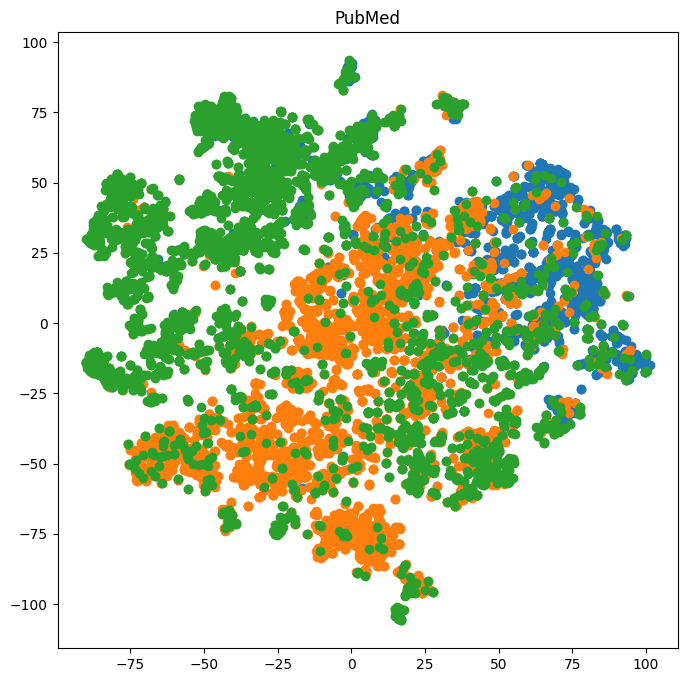

classification try  1  acc 0.816
classification try  2  acc 0.805
classification try  3  acc 0.811


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


classification try  4  acc 0.8055
classification try  5  acc 0.796
classification try  6  acc 0.804
classification try  7  acc 0.7955
classification try  8  acc 0.7985
classification try  9  acc 0.803
classification try  10  acc 0.803
Maximum Accuracy: 0.816 , Average Accuracy:  0.80375


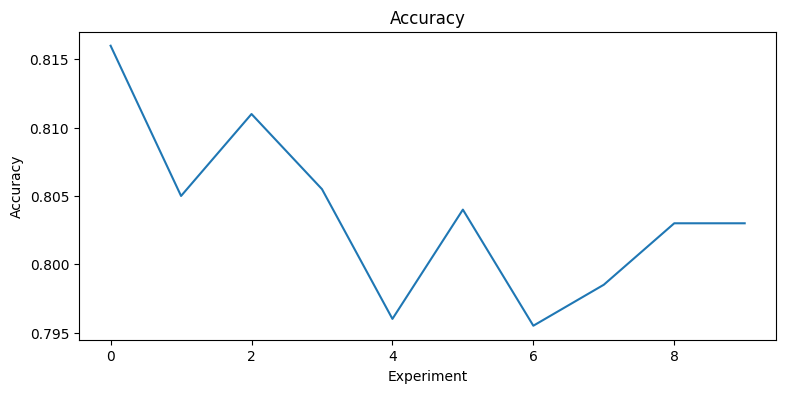

Maximum Precision: 0.81799894629649 , Average Precision:  0.8061932503298124


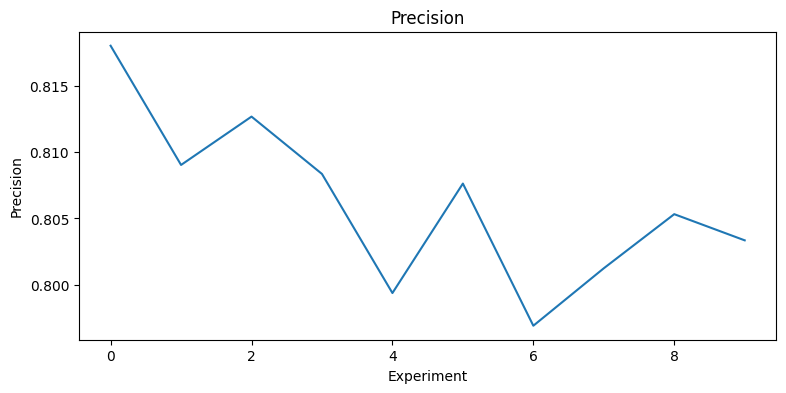

Maximum Recall: 0.816 , Average Recall:  0.80375


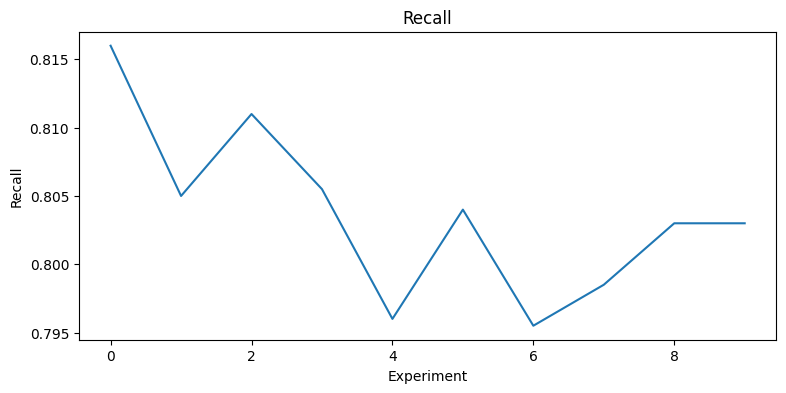

Maximum F1 Measure: 0.8155249346934357 , Average F1 Measure:  0.8030847027643382


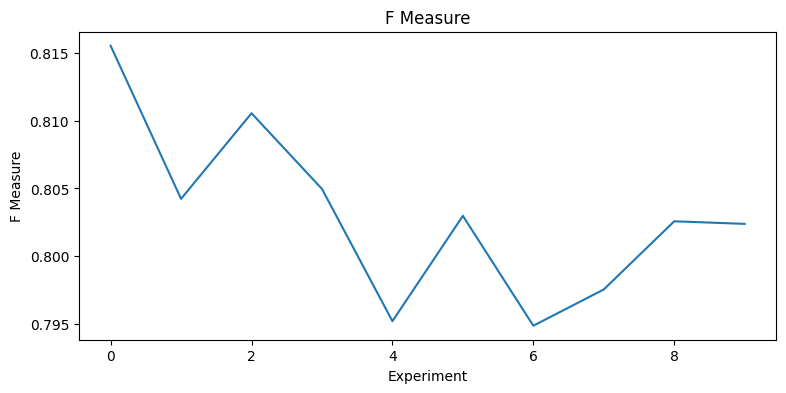

In [ ]:
main_gcn_pubmed()


In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, input_dim,output_dim):
        super(GCN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        # hidden layer node features
        self.hidden1 = input_dim*2-int(input_dim*2 % output_dim)      #pubmed input_dim*3 cora,citeseer*2
        self.hidden2 = self.hidden1*4
        self.hidden3 = int(self.hidden2/2)
        self.hidden4 = int(self.hidden3)-2*output_dim
        self.hidden5 = self.hidden4-4*output_dim     #cora:-4out_dim  pubmed:-4*out_dim cite:-4out_dim
        #self.hidden6 = self.hidden5-output_dim
        #self.hidden7 = self.hidden5-output_dim
        self.conv1 = GCNConv(self.input_dim, self.hidden1)
        self.conv2 = GCNConv(self.hidden1, self.hidden2)
        self.conv3 = GCNConv(self.hidden2, self.hidden3)
        self.conv4 = GCNConv(self.hidden3, self.hidden4)
        self.conv5 = GCNConv(self.hidden4, self.hidden5)
        self.conv6 = GCNConv(self.hidden5, self.output_dim)
        #self.conv7 = GCNConv(self.hidden6, self.hidden7)
        #self.conv8 = GCNConv(self.hidden7, self.output_dim)

        #self.linear= torch.nn.Linear(128, self.output_dim)

    def forward(self, x,edge_index):
        x = self.conv1(x, edge_index)
        #x = F.leaky_relu(x,-0.1)
        x = F.tanh(x)
        #x = F.dropout(x, p=0.3, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.tanh(x)
        #x = F.dropout(x, p=0.3, training=self.training)
        x = self.conv3(x, edge_index)
        x = F.tanh(x)
        x = self.conv4(x, edge_index)
        x = F.tanh(x)
        x = self.conv5(x, edge_index)
        x = F.tanh(x)
        x = self.conv6(x, edge_index)
        #x = F.tanh(x)
        #x = self.conv7(x, edge_index)
        #x = F.tanh(x)
        #x = self.conv8(x, edge_index)
        output = F.tanh(x)
        #output = F.dropout(x, p=0.1, training=self.training)
        #output = self.linear(x)
        return output

    def weight_initilizer(self):
        torch.nn.init.xavier_normal_(self.conv1.lin.weight.data,gain=1)
        torch.nn.init.xavier_normal_(self.conv2.lin.weight.data,gain=1)
        torch.nn.init.xavier_normal_(self.conv3.lin.weight.data,gain=1)
        torch.nn.init.xavier_normal_(self.conv4.lin.weight.data,gain=1)
        torch.nn.init.xavier_normal_(self.conv5.lin.weight.data,gain=1)
        torch.nn.init.xavier_normal_(self.conv6.lin.weight.data,gain=1)
        #torch.nn.init.xavier_normal_(self.conv7.lin.weight.data,gain=1)
        #torch.nn.init.xavier_normal_(self.conv8.lin.weight.data,gain=1)

In [ ]:
def main_gcn_citeseer():
    my_device = "cuda" if torch.cuda.is_available() else "cpu"
    dataset_name = 'CiteSeer'        #CiteSeer  Cora  PubMed
    target_dimention=512

    transform = T.Compose([
        #T.RandomNodeSplit(num_val=500, num_test=500),
        T.TargetIndegree(),     #TargetIndegree
    ])
    path = os.path.join(sys.path[0],"dataset")
    dataset = Planetoid(path, dataset_name, transform=transform)
    data = dataset[0]
    model=GCN(data.x.shape[1],target_dimention)
    model,losses=gcn_trainer(model,data,target_dimention,my_device)
    model.eval()
    X_embeded_gcn = model(data.x.to(my_device),data.edge_index.to(my_device))
    labels=data.y.detach().numpy()
    labels_unique=np.unique(labels)

    X = X_embeded_gcn.cpu().detach().numpy()
    tsne_model = TSNE(n_components=2, random_state=0)
    x_redued = tsne_model.fit_transform(X)

    plt.figure(figsize=(8,8))

    for label in labels_unique:
        items=x_redued[labels==label]
        plt.scatter(items[:,0] ,items[:,1])

    plt.title(dataset_name)
    plt.show()
    accuracy_list,precision_list,recall_list,F1_list=Classifier(X,labels,.2)
    plot_results(accuracy_list,precision_list,recall_list,F1_list)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:999: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([512, 512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)


Epoch No: 1  , Loss: 6.619399070739746
Epoch No: 2  , Loss: 61.67501449584961
Epoch No: 3  , Loss: 75.3064956665039
Epoch No: 4  , Loss: 12.303651809692383
Epoch No: 5  , Loss: 8.556291580200195
Epoch No: 6  , Loss: 21.379772186279297
Epoch No: 7  , Loss: 7.285754203796387
Epoch No: 8  , Loss: 9.746408462524414
Epoch No: 9  , Loss: 6.624624252319336
Epoch No: 10  , Loss: 13.284224510192871
Epoch No: 11  , Loss: 6.860284328460693
Epoch No: 12  , Loss: 8.23774242401123
Epoch No: 13  , Loss: 6.999693393707275
Epoch No: 14  , Loss: 5.557436466217041
Epoch No: 15  , Loss: 5.491249084472656
Epoch No: 16  , Loss: 7.654247283935547
Epoch No: 17  , Loss: 22.979299545288086
Epoch No: 18  , Loss: 9.456409454345703
Epoch No: 19  , Loss: 9.439998626708984
Epoch No: 20  , Loss: 5.041324615478516
Epoch No: 21  , Loss: 4.669318199157715
Epoch No: 22  , Loss: 5.3939361572265625
Epoch No: 23  , Loss: 4.995607376098633
Epoch No: 24  , Loss: 4.048982620239258
Epoch No: 25  , Loss: 5.566689491271973
Epoch 

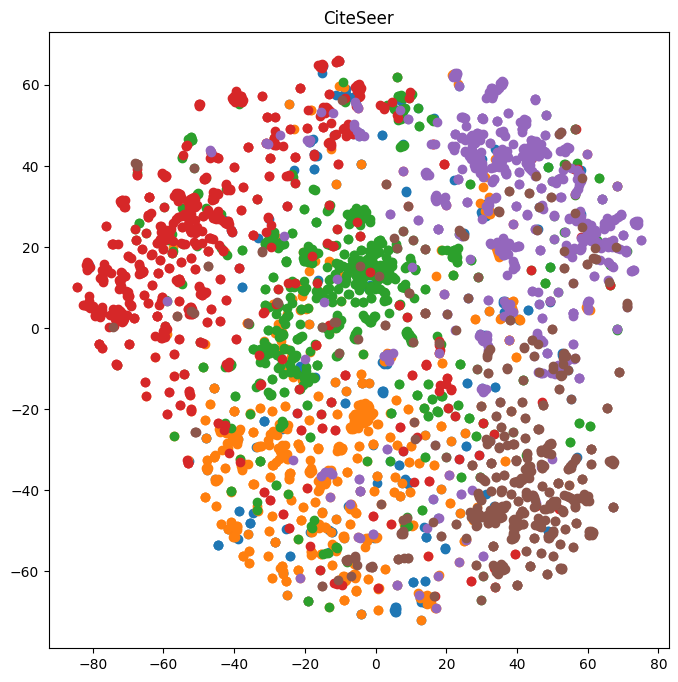

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

classification try  1  acc 0.7747747747747747
classification try  2  acc 0.7462462462462462


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

classification try  3  acc 0.7687687687687688
classification try  4  acc 0.7552552552552553


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


classification try  5  acc 0.7237237237237237


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

classification try  6  acc 0.7507507507507507
classification try  7  acc 0.7972972972972973


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

classification try  8  acc 0.7597597597597597
classification try  9  acc 0.7792792792792793


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


classification try  10  acc 0.7627627627627628
Maximum Accuracy: 0.7972972972972973 , Average Accuracy:  0.7618618618618618


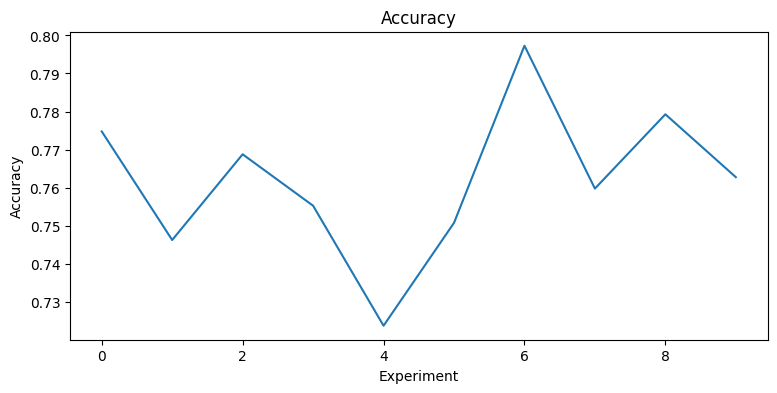

Maximum Precision: 0.793612720906238 , Average Precision:  0.7589531875884175


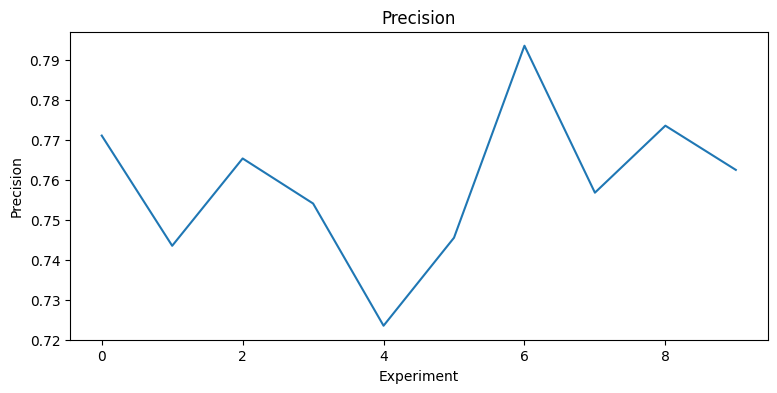

Maximum Recall: 0.7972972972972973 , Average Recall:  0.7618618618618618


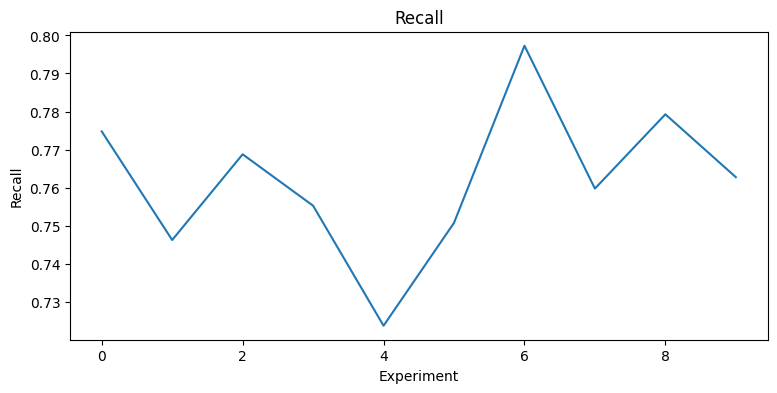

Maximum F1 Measure: 0.793748536887129 , Average F1 Measure:  0.7579322692273435


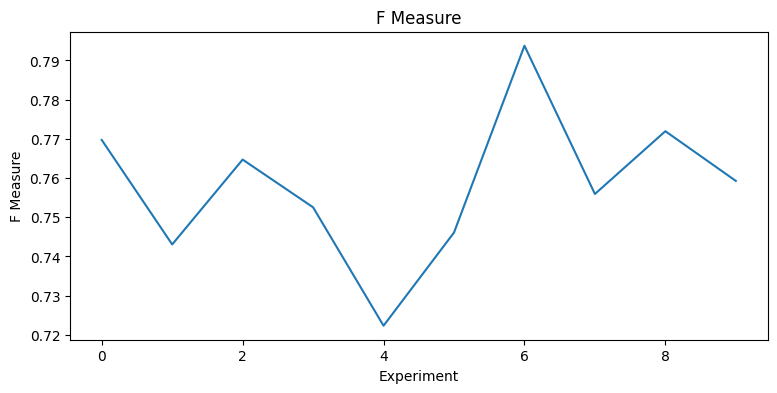

In [ ]:
main_gcn_citeseer()

In [ ]:
def main_gcn_cora():
    my_device = "cuda" if torch.cuda.is_available() else "cpu"
    dataset_name = 'Cora'        #CiteSeer  Cora  PubMed
    target_dimention=512

    transform = T.Compose([
        #T.RandomNodeSplit(num_val=500, num_test=500),
        T.TargetIndegree(),     #TargetIndegree
    ])
    path = os.path.join(sys.path[0],"dataset")
    dataset = Planetoid(path, dataset_name, transform=transform)
    data = dataset[0]
    model=GCN(data.x.shape[1],target_dimention)
    model,losses=gcn_trainer(model,data,target_dimention,my_device)
    model.eval()
    X_embeded_gcn = model(data.x.to(my_device),data.edge_index.to(my_device))
    labels=data.y.detach().numpy()
    labels_unique=np.unique(labels)

    X = X_embeded_gcn.cpu().detach().numpy()
    tsne_model = TSNE(n_components=2, random_state=0)
    x_redued = tsne_model.fit_transform(X)

    plt.figure(figsize=(8,8))

    for label in labels_unique:
        items=x_redued[labels==label]
        plt.scatter(items[:,0] ,items[:,1])

    plt.title(dataset_name)
    plt.show()
    accuracy_list,precision_list,recall_list,F1_list=Classifier(X,labels,.2)
    plot_results(accuracy_list,precision_list,recall_list,F1_list)


Processing...
Done!
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:999: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([512, 512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)


Epoch No: 1  , Loss: 6.173646450042725
Epoch No: 2  , Loss: 32.33755874633789
Epoch No: 3  , Loss: 13.877119064331055
Epoch No: 4  , Loss: 8.321885108947754
Epoch No: 5  , Loss: 7.384460926055908
Epoch No: 6  , Loss: 6.12385892868042
Epoch No: 7  , Loss: 5.772052764892578
Epoch No: 8  , Loss: 5.4310126304626465
Epoch No: 9  , Loss: 5.215415000915527
Epoch No: 10  , Loss: 4.9761528968811035
Epoch No: 11  , Loss: 4.753044128417969
Epoch No: 12  , Loss: 4.579593181610107
Epoch No: 13  , Loss: 4.454488277435303
Epoch No: 14  , Loss: 4.352510929107666
Epoch No: 15  , Loss: 4.252203941345215
Epoch No: 16  , Loss: 4.147395610809326
Epoch No: 17  , Loss: 4.0376458168029785
Epoch No: 18  , Loss: 3.9309802055358887
Epoch No: 19  , Loss: 3.8355085849761963
Epoch No: 20  , Loss: 3.7551052570343018
Epoch No: 21  , Loss: 3.6902694702148438
Epoch No: 22  , Loss: 3.6347031593322754
Epoch No: 23  , Loss: 3.5816779136657715
Epoch No: 24  , Loss: 3.529447555541992
Epoch No: 25  , Loss: 3.4777514934539795

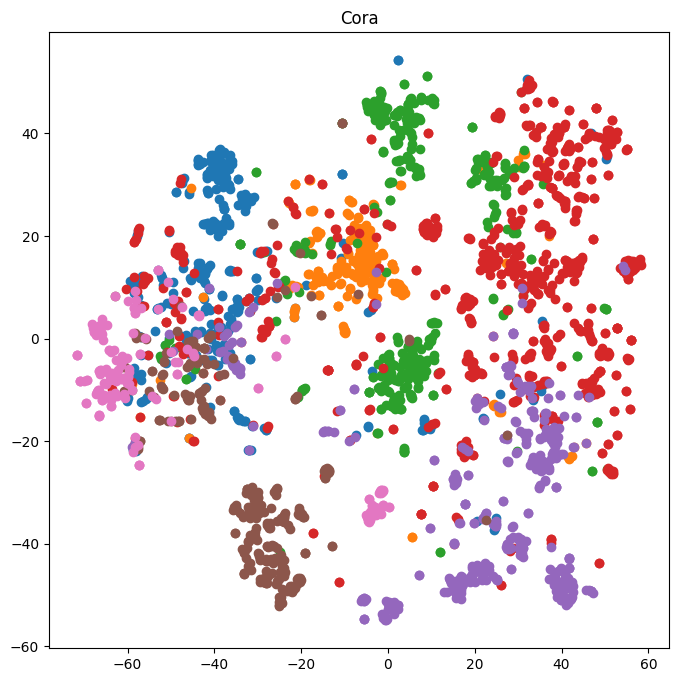

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

classification try  1  acc 0.8929889298892989
classification try  2  acc 0.8985239852398524


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


classification try  3  acc 0.8782287822878229


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


classification try  4  acc 0.8800738007380073


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


classification try  5  acc 0.8819188191881919


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


classification try  6  acc 0.8800738007380073


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


classification try  7  acc 0.8542435424354243


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


classification try  8  acc 0.8782287822878229


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


classification try  9  acc 0.8856088560885609
classification try  10  acc 0.8690036900369004
Maximum Accuracy: 0.8985239852398524 , Average Accuracy:  0.879889298892989


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


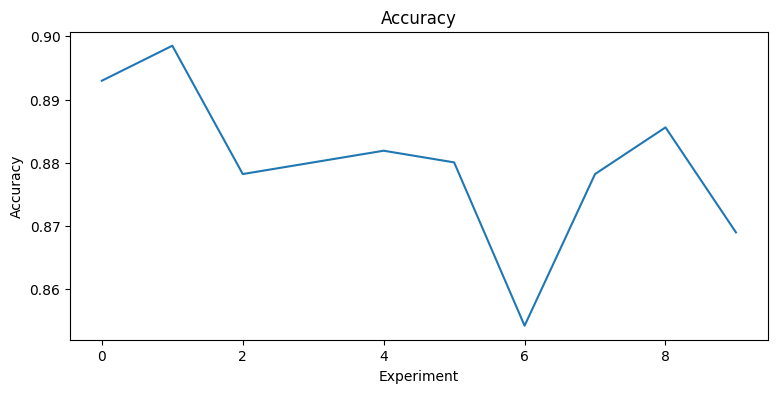

Maximum Precision: 0.898394327076116 , Average Precision:  0.8833209718707099


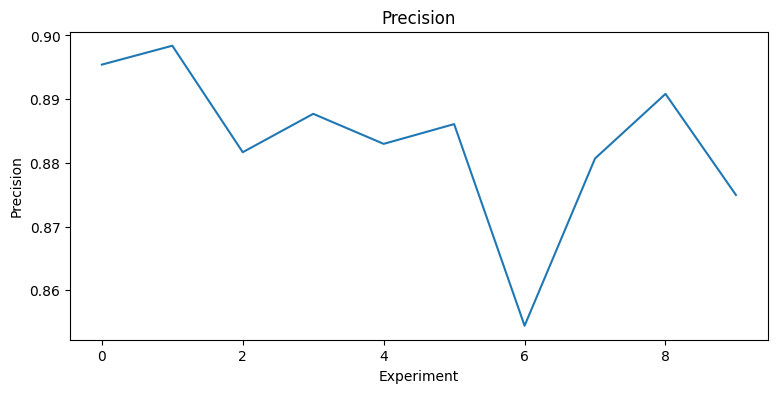

Maximum Recall: 0.8985239852398524 , Average Recall:  0.879889298892989


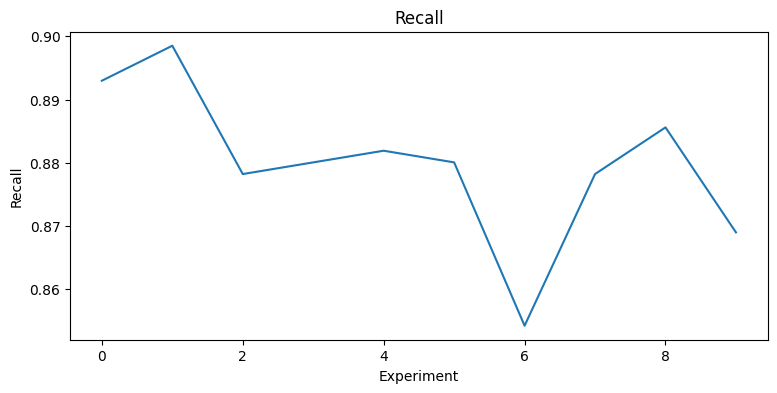

Maximum F1 Measure: 0.8983985546521089 , Average F1 Measure:  0.8805418522312378


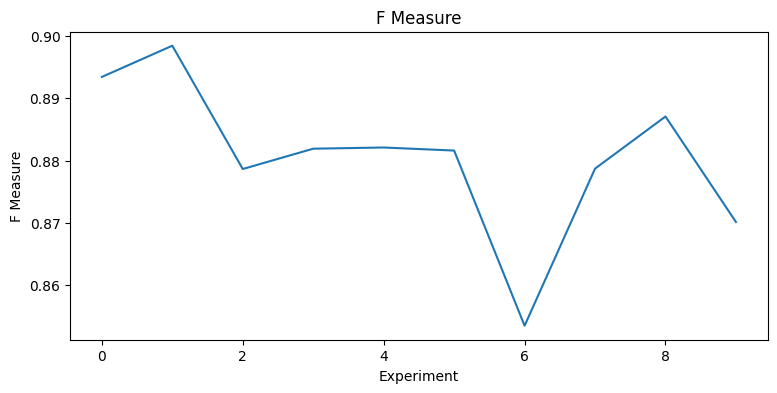

In [ ]:
main_gcn_cora()